# 11_1 In class example, Classification with questions
We will load the breast cancer dataset and figure out what is the most important predictor(s) for breast cancer. And then see what happens to the prognosis when these predictors are permuted.

<mark>Note:  Any data gleaned from this sort of thing is only as good as your model.  So if your model is very bad at making predictions then it's notions about what are the most important predictors are also very bad!

<!--See <a href="https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py">this</a> page for a different take on removing correlated columns-->

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# Load Data

In [2]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
# X, y = data.data, data.target
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
#want to see it all in a dataframe?
df = pd.DataFrame(data= np.c_[data['data']],
                     columns= data['feature_names'])
df.head()
y=pd.Series(data['target'])

In [4]:
#there are no nulls
%time
df.isnull().sum().sum()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.53 µs


0

In [5]:
#is it balanced?
print(f' %{y.sum()/y.shape[0]*100} of dataset is non-cancerous')

 %62.741652021089635 of dataset is non-cancerous


## Any correlations?  If so dump em
Correlations interfere with calculating importance.  For instance, if you have 2 highly correlated columns; A and B.  If you scramble A then B still has As information.  This will result in a lower importance value for both features, where they might actually be important.

In [6]:
# fig, ax = plt.subplots(figsize=(15, 15))
corr = df.corr(method='spearman').abs()

# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

#BTW how do you choose a threshold here? If you vary this from .98 to .65 you will see a decrease and then increase in model accuracy.
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
print(f'Dropping {to_drop}')
df=df.drop(columns=to_drop)

Dropping ['mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'perimeter error', 'area error', 'compactness error', 'concavity error', 'concave points error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


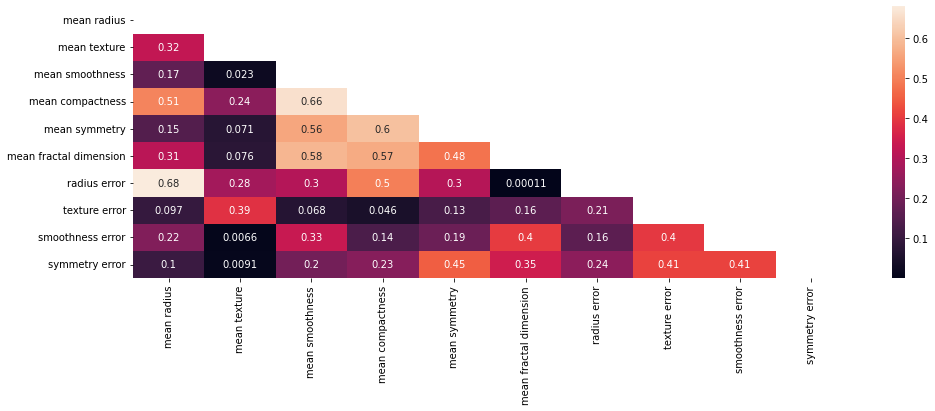

In [7]:
#make the heatmap fit on the screen
plt.figure(figsize=(16, 5))

# generate the correlation matrix (abs converts to absolute value, this way we only look for 1 color range)
corr = df.corr().abs()

# Generate mask for the upper triangle (see https://seaborn.pydata.org/examples/many_pairwise_correlations.html)
# the matrix is symmetric, the diagonal (all 1's) and upper triangle are visual noise, use this to mask both out
mask = np.tril(np.ones_like(corr, dtype=bool), k=-1)    #k=-1 means get rid of the diagonal

corr = corr.where(cond=mask)

sns.heatmap(corr, annot=True);

# Recursive Feature Elimination

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

min_features_to_select = 5  # Minimum number of features to consider
clf = RandomForestClassifier(n_estimators=100, random_state=42)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=StratifiedKFold(2),
    min_features_to_select=min_features_to_select,
)
rfecv.fit(df, y)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 10


In [9]:
df=df.loc[:,rfecv.support_]

In [10]:
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (accuracy)")
# plt.plot(
#     range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
#     rfecv.grid_scores_,
# )
# plt.show()

# Get train test split

In [11]:
#get train test split
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)

# Train a model

In [12]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

Accuracy on test data: 0.95


# Permutation importance

In [13]:
from sklearn.inspection import permutation_importance

In [14]:
%%time
result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, random_state=42,  scoring='accuracy')
forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

CPU times: user 814 ms, sys: 0 ns, total: 814 ms
Wall time: 812 ms


In [15]:
# fig, ax = plt.subplots(figsize=(10,7))
# forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
# ax.set_title("Random Forest feature importance via permutation importance")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

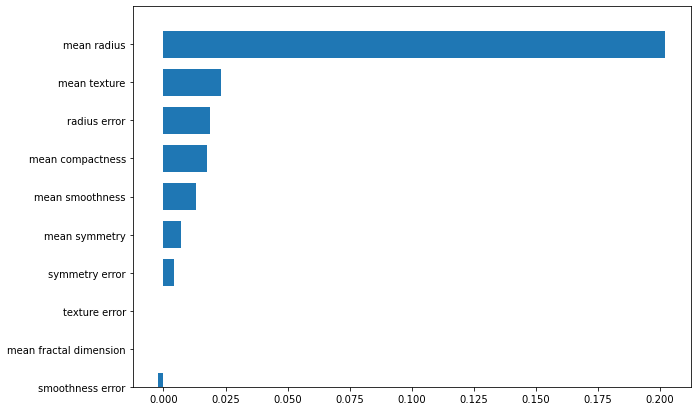

In [16]:
#plot em
forest_importances = forest_importances.sort_values(ascending=True)
tree_indices = forest_importances.index

fig, ax = plt.subplots(figsize=(10,7))
_=ax.barh(tree_indices, forest_importances, height=0.7)
_=ax.set_yticks(tree_indices)
_=ax.set_yticklabels(tree_indices)
_=ax.set_ylim((0, len(tree_indices)))


In [17]:
# forest_importances
# forest_importances.index
# forest_importances
# # forest_importances['mean radius']

# ICE It looks like 'mean radius' matters quite a bit.  What happens if it's permuted?

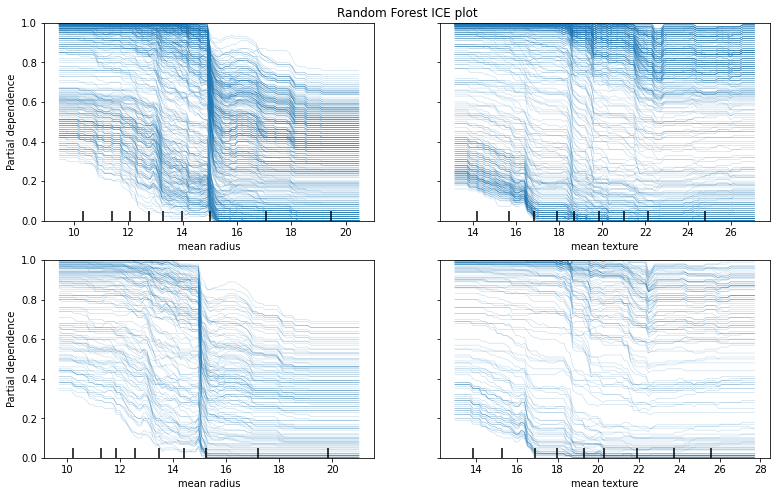

In [19]:
fig, (ax,ax1) = plt.subplots(2,1,figsize=(13, 8))
ax.set_title("Random Forest ICE plot")
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(clf, X_train, features=[0,1],kind='individual', ax=ax)
PartialDependenceDisplay.from_estimator(clf, X_test, features=[0,1],kind='individual', ax=ax1)

# And the PDP

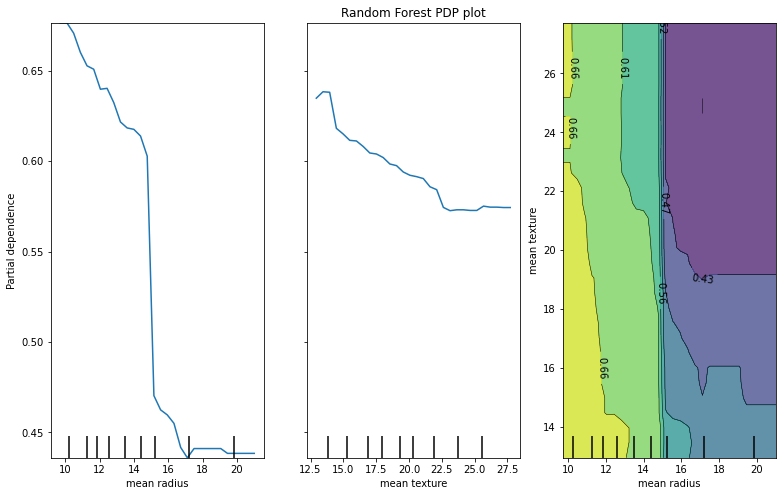

In [46]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(13, 8))
ax.set_title("Random Forest PDP plot")
my_plots = PartialDependenceDisplay.from_estimator(clf, 
                                   features=[0,1,(0,1)], 
                                   X=X_test, 
                                   feature_names=['mean radius','mean texture'], 
                                   grid_resolution=30, ax=ax)

# Lets 3d plot these features

/tmp/ipykernel_16121/2781677896.py:14: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


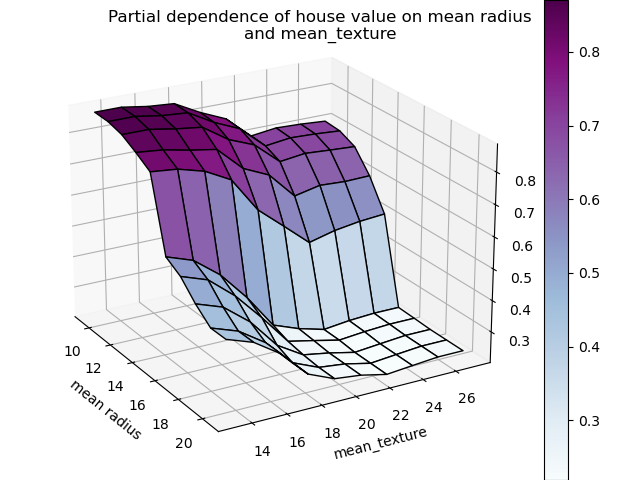

In [20]:
from sklearn.inspection import partial_dependence,plot_partial_dependence
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
%matplotlib ipympl
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

# features = ("AveOccup", "HouseAge")
pdp = partial_dependence(
    clf, X_train, features=[0,1], kind="average", grid_resolution=10
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
fig.add_axes(ax)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel('mean radius')
ax.set_ylabel('mean_texture')
ax.set_zlabel("Partial dependence")
# pretty init view
ax.view_init(elev=22, azim=-30)
plt.colorbar(surf)
plt.suptitle(
    "Partial dependence of diagnosis on mean radius\n"
    "and mean_texture"
)
plt.subplots_adjust(top=0.9)
plt.show()